In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 16})

In [12]:
# fitting to a fct
def exp(t, A, lbda):
    r"""y(t) = A \cdot \exp(-\lambda t)"""
    return A * np.exp(-lbda * t)

def sine(t, omega, phi):
    r"""y(t) = \sin(\omega \cdot t + phi)"""
    return np.sin(omega * t + phi)

def damped_sine(t, A, lbda, omega, phi):
    r"""y(t) = A \cdot \exp(-\lambda t) \cdot \left( \sin \left( \omega t + \phi ) \right)"""
    return exp(t, A, lbda) * sine(t, omega, phi)

from scipy.optimize import curve_fit

start = 520
popt, pcov = curve_fit(f, (data[start:,0]-data[0,0]), data[start:,1])
print(start)
print(*[f"{val:.2f}+/-{err:.2f}" for val, err in zip(popt, np.sqrt(np.diag(pcov)))])

plt.plot((data[start:,0]-data[0,0]), data[start:,1], ".")
plt.plot((data[start:,0]-data[0,0]), f((data[start:,0]-data[0,0]), *popt))
plt.show()

NameError: name 'f' is not defined

## Calculating control error and steady state temperature

Steady state temp: -9.601771713678376 +- 0.005905602051794671
Residual control error: 0.39822828632162377 +- 0.005905602051794671
Stability: 0.010383340923793248
Response time: 29.666666666666668 +- 6.553031529164379


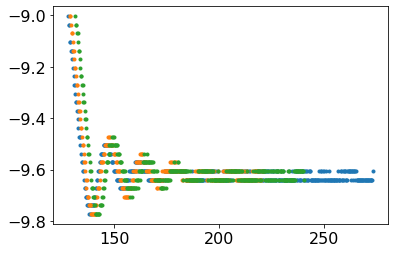

In [40]:
paths = ["../data/e3_1_-10_run1.raw",
        "../data/e3_1_-10_run2.raw",
        "../data/e3_1_-10_run3.raw"]

# calculating stuff

set_pt_temp = -10
band = 1
ss = np.zeros(len(paths))
stab = np.zeros(len(paths))
rt = np.zeros(len(paths))

for i, path in enumerate(paths):
    data = np.genfromtxt(path, skip_header=13, delimiter=",")
    lim = int(len(data[:,1])/2)
    
    # calculate when it enters the band
    up = set_pt_temp+band
    start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
    
    # calculate the last point where it's outside of the steady state +- resolution
    resolution = 0.03125
    end = np.where(data[:,1] > (steady_state + resolution))[0][-1]
    
    # calculate response time
    rt[i] = (data[:,0]-data[0,0])[end] - (data[:,0]-data[0,0])[start]
    
    # steady-state temperature
    ss[i] = np.mean(data[:,1][start:])
    
    # quantify stability
    stab[i] = np.std(data[:,1])/len(data[:,1])
    
    start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
    plt.plot((data[start:,0]-data[0,0]), data[start:,1], ".")
    
    
# calculate residual control error and steady state temp
steady_state = np.mean(ss)
print("Steady state temp:", steady_state, "+-", np.std(ss))
residual_control_error = steady_state - set_pt_temp
print("Residual control error:", residual_control_error, "+-", np.std(ss))

# calculate system stability
stability = np.mean(stab)
print("Stability:", stability)

# calculate response time
response_time = np.mean(rt)
print("Response time:", response_time, "+-", np.std(rt))

# Set-point temperature: -10C

## Implementing response time

-9.59506941838649



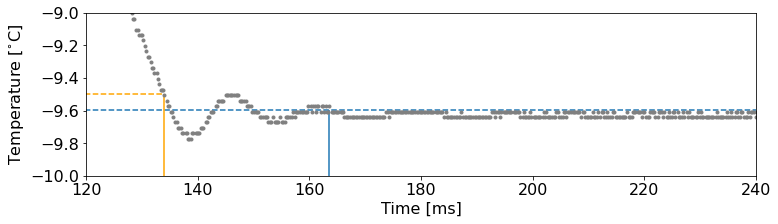

29.599999999999966


In [160]:
path = "../data/e3_1_-10_run1.raw"

plt.figure(figsize=(12,3))

data = np.genfromtxt(path, skip_header=13, delimiter=",")
plt.plot(data[:,0]-data[0,0], data[:,1], ".", color="gray")

set_pt_temp = -10
band = 1/2

lim = int(len(data[:,1])/2)
    
# steady-state temperature
steady_state = np.mean(data[:,1][lim:])

# calculate when it enters the band
up = set_pt_temp+band
start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]

# calculate the last point where it's outside of the steady state +- resolution
resolution = 0.03
end = np.where(data[:,1] > (steady_state + resolution))[0][-1]
print(steady_state + resolution)
print()
#plt.hlines(set_pt_temp, 0, 280, linestyle="--", colors="gray")
plt.hlines(set_pt_temp+band, 0, (data[:,0]-data[0,0])[start], linestyle="--", colors="orange")
plt.hlines(steady_state+resolution, 0, 280, linestyle="--", colors="C0")
plt.vlines((data[:,0]-data[0,0])[start], set_pt_temp-band, set_pt_temp+band, colors="orange")
plt.vlines((data[:,0]-data[0,0])[end], set_pt_temp-band, steady_state+ resolution)
plt.ylabel("Temperature [$^{\circ}$C]")
plt.xlabel("Time [ms]")
plt.ylim(set_pt_temp, set_pt_temp+band*2)
plt.xlim(120, 240)
plt.show()

response_time = (data[:,0]-data[0,0])[end] - (data[:,0]-data[0,0])[start]
print(response_time)

## Implementing response time: trying to fit only the peaks

-9.601771713678376


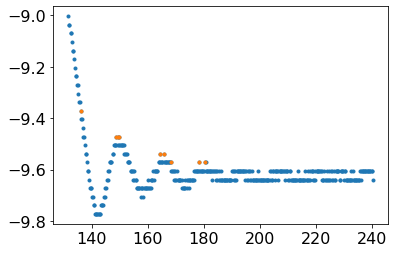

In [58]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# calculate when it enters the band
up = set_pt_temp+band
start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]

# find the peaks
peaks = find_peaks(data[start:,1], height=steady_state, prominence=0.001)[0]
print(steady_state)


plt.plot((data[start:,0]-data[0,0]), data[start:,1], ".")
plt.plot((data[start:,0]-data[0,0])[peaks], data[start:,1][peaks], ".")
plt.show()

# Turning it into a pipeline

In [211]:
def exercise_3(datapaths: list, set_pt_temp, band, overshoot=True):
    
    # calculating stuff
    band = band/2
    
    ss = np.zeros(len(datapaths))
    stab = np.zeros(len(datapaths))
    rt = np.zeros(len(datapaths))
    
    plt.figure(figsize=(10,4))

    for i, path in enumerate(datapaths):
        data = np.genfromtxt(path, skip_header=13, delimiter=",")
        

        # calculate when it enters the band
        up = set_pt_temp+band
        start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
        
        
        # steady-state temperature
        ss[i] = np.mean(data[:,1][start:])

        # quantify stability
        stab[i] = np.std(data[:,1])**2#/np.sqrt(len(data[:,1]))

        start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
        plt.plot((data[start:,0]-data[0,0]), data[start:,1], ".")


    # calculate residual control error and steady state temp
    steady_state = np.mean(ss)
    print("Steady state temp:", steady_state, "+-", np.std(ss))
    residual_control_error = steady_state - set_pt_temp
    print("Residual control error:", residual_control_error, "+-", np.std(ss))

    # calculate system stability
    stability = np.mean(stab)
    print("Stability:", stability)
    
    for i, path in enumerate(datapaths):
        
        data = np.genfromtxt(path, skip_header=13, delimiter=",")
        
        # calculate where it enters the band
        up = set_pt_temp+band
        start = np.where(abs(data[:,1]-up) == abs(data[:,1]-up).min())[0][0]
        
        # halfway point after it enters the band
        half = int(len(data[start:,1])/3) + start
        #print(start, half)
        
        # calculate the last point where it's outside of the steady state +- resolution
        resolution = 0.03125
        if overshoot:
            end = np.where(data[start:half,1] > (steady_state + resolution))[0][-1]
        else: 
            end = np.where(data[start:half,1] < (steady_state + resolution))[0][-1]
        #print("end:", end)
        # calculate response time
        rt[i] = (data[:,0]-data[0,0])[start+end] - (data[:,0]-data[0,0])[start]
        
        ### ANOTHER STABILITY ESTIMATE
        # quantify stability from when it enters the band
        stab[i] = np.std(data[start:,1])**2
        

    # calculate response time
    response_time = np.mean(rt)
    print("Response time:", response_time, "+-", np.std(rt))
    print(stab)
    
    plt.hlines(set_pt_temp+band, (data[start:,0]-data[0,0])[0], (data[:,0]-data[0,0])[start], linestyle="--", colors="gray")
    plt.hlines(steady_state, (data[start:,0]-data[0,0])[0], 280, linestyle="--", colors="gray")
    plt.vlines((data[:,0]-data[0,0])[start], set_pt_temp, set_pt_temp+band)
    plt.vlines((data[:,0]-data[0,0])[end+start], set_pt_temp, steady_state)
    plt.show()
    
    return {"rt" : response_time,
           "rt_err" : np.std(rt),
           "stab" : stability,
           "stab_err" : np.std(stab),
           "steady_state_temp" : steady_state,
           "steady_state_temp_err" : np.std(ss),
           "control_error" : residual_control_error,
           "control_error_err" : np.std(ss)}

# Temperature -10C
## Band = 1

Steady state temp: -9.621997091224403 +- 0.0019482078599647845
Residual control error: 0.3780029087755974 +- 0.0019482078599647845
Stability: 97.39962970152082
Response time: 29.53333333333332 +- 1.0624918300339108
[0.00126502 0.00267469 0.00211811]


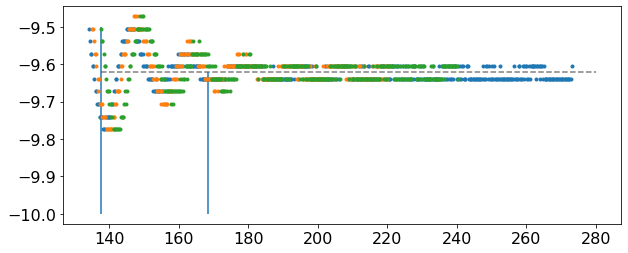

In [212]:
paths = ["../data/e3_1_-10_run1.raw",
        "../data/e3_1_-10_run2.raw",
        "../data/e3_1_-10_run3.raw"]

band_1 = exercise_3(paths, -10, 1)

## Band = 3

Steady state temp: -8.908353203529499 +- 0.0076703795645521565
Residual control error: 1.091646796470501 +- 0.0076703795645521565
Stability: 85.10383511726239
Response time: 39.59999999999999 +- 8.120755301489316
[0.00317347 0.00339794 0.00456956]


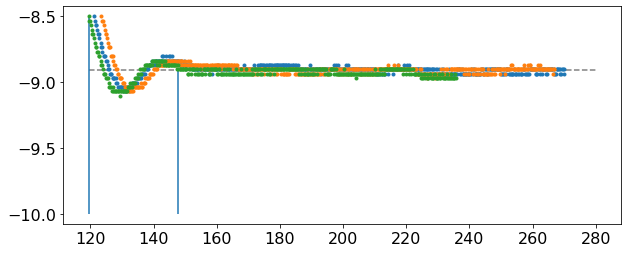

In [213]:
paths = ["../data/e3_3_-10_run1.raw",
        "../data/e3_3_-10_run2.raw",
        "../data/e3_3_-10_run3.raw"]

band_3 = exercise_3(paths, -10, 3)

## Band = 4.8

Steady state temp: -8.27068135162485 +- 0.007142972529623559
Residual control error: 1.7293186483751501 +- 0.007142972529623559
Stability: 90.17131533958127
Response time: 49.4 +- 17.065364533658993
[0.01147768 0.01159103 0.00672197]


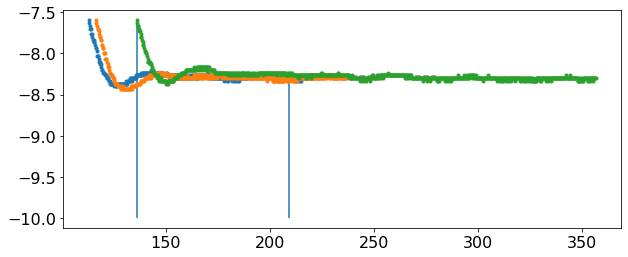

In [214]:
paths = [
        "../data/e3_4.8_-10_run2.raw",
        "../data/e3_4.8_-10_run3.raw",
"../data/e3_4.8_-10_run1.raw"]

band_48 = exercise_3(paths, -10, 4.8, overshoot=False)

## Band = 8

Steady state temp: -7.288908569299582 +- 0.023174536541612768
Residual control error: 2.711091430700418 +- 0.023174536541612768
Stability: 85.20964960037192
Response time: 44.06700000000001 +- 14.335802895780434
[0.03428741 0.05644445 0.071742  ]


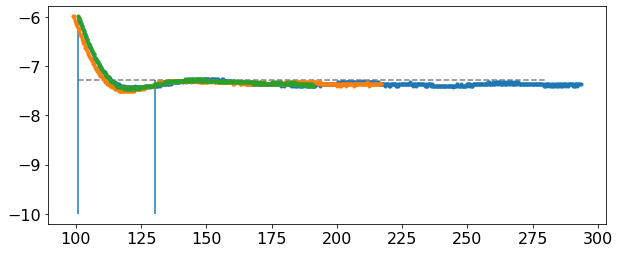

In [215]:
paths = ["../data/e3_8_-10_run1.raw",
        "../data/e3_8_-10_run2.raw",
        "../data/e3_8_-10_run3.raw"]

band_8 = exercise_3(paths, -10, 8, overshoot=False)

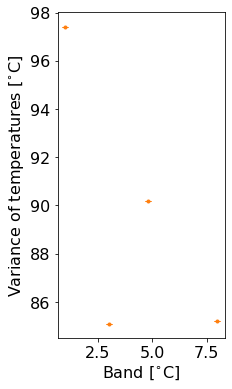

In [208]:
stab = [band_1["stab"], band_3["stab"], band_48["stab"], band_8["stab"]]
stab_err = [band_1["stab_err"], band_3["stab_err"], band_48["stab_err"], band_8["stab_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], stab, stab_err, fmt="C1.", capsize=3)
plt.ylabel("Variance of temperatures [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

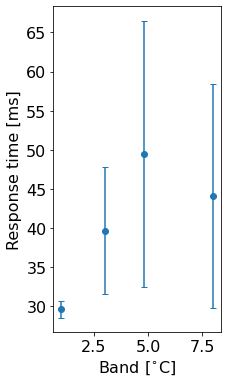

In [209]:
rt = [band_1["rt"], band_3["rt"], band_48["rt"], band_8["rt"]]
rt_err = [band_1["rt_err"], band_3["rt_err"], band_48["rt_err"], band_8["rt_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], rt, rt_err, fmt="o", capsize=3)
plt.ylabel("Response time [ms]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

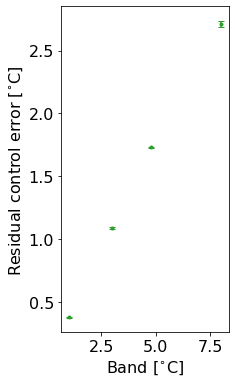

In [210]:
control_error = [band_1["control_error"], band_3["control_error"], band_48["control_error"], band_8["control_error"]]
control_error_err = [band_1["control_error_err"], band_3["control_error_err"], band_48["control_error_err"], band_8["control_error_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], control_error, control_error_err, fmt="C2.", capsize=3)
plt.ylabel("Residual control error [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

Steady state temp: 44.67909377278377 +- 0.0015265573800524936
Residual control error: -0.3209062272162271 +- 0.0015265573800524936
Stability: 28.451724496107232
Response time: 46.53333333333333 +- 1.9136933459209688
[0.01308334 0.01302068 0.01138163]


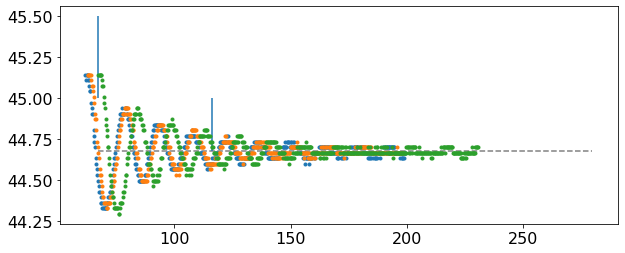

Steady state temp: 44.07691291966796 +- 0.0018369680791209908
Residual control error: -0.9230870803320386 +- 0.0018369680791209908
Stability: 31.06432417256249
Response time: 23.933333333333323 +- 0.8219218670625307
[0.01967001 0.02252812 0.01940601]


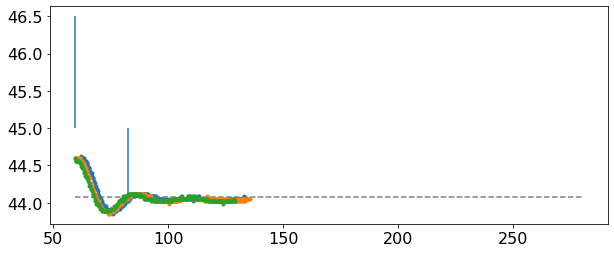

Steady state temp: 43.546960604832044 +- 0.026253417287179847
Residual control error: -1.4530393951679557 +- 0.026253417287179847
Stability: 35.99521286363242
Response time: 10.33333333333333 +- 0.659966329107448
[0.02146554 0.02124772 0.01919554]


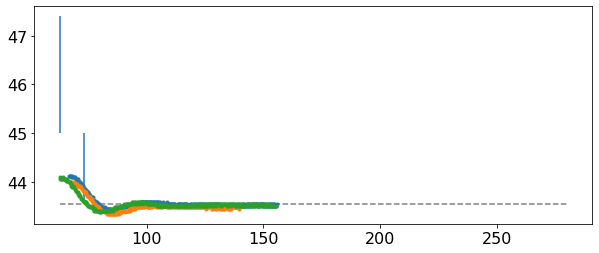

Steady state temp: 42.68610704458977 +- 0.009437894594818589
Residual control error: -2.313892955410232 +- 0.009437894594818589
Stability: 31.14610381895047
Response time: 15.799999999999999 +- 0.2828427124746146
[0.02070501 0.01844138 0.01957207]


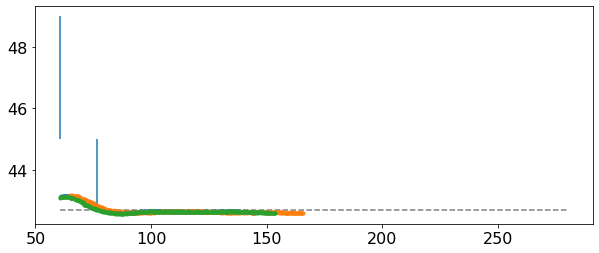

In [224]:
paths = [
        "../data/e3_1_45_run2.raw",
        "../data/e3_1_45_run3.raw",
"../data/e3_1_45_run1.raw"]

band_1 = exercise_3(paths, 45, 1, overshoot=True)

paths = [
        "../data/e3_3_45_run2.raw",
        "../data/e3_3_45_run3.raw",
"../data/e3_3_45_run1.raw"]

band_3 = exercise_3(paths, 45, 3, overshoot=True)

paths = [
        "../data/e3_4.8_45_run2.raw",
        "../data/e3_4.8_45_run3.raw",
"../data/e3_4.8_45_run1.raw"]

band_48 = exercise_3(paths, 45, 4.8, overshoot=True)

paths = [
        "../data/e3_8_45_run2.raw",
        "../data/e3_8_45_run3.raw",
"../data/e3_8_45_run1.raw"]

band_8 = exercise_3(paths, 45, 8, overshoot=True)

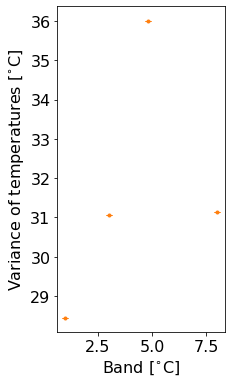

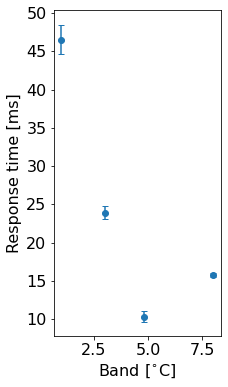

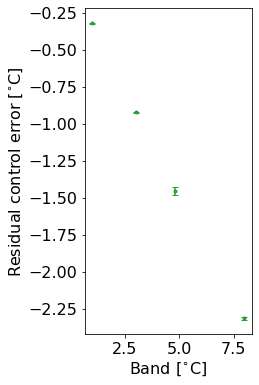

In [225]:
stab = [band_1["stab"], band_3["stab"], band_48["stab"], band_8["stab"]]
stab_err = [band_1["stab_err"], band_3["stab_err"], band_48["stab_err"], band_8["stab_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], stab, stab_err, fmt="C1.", capsize=3)
plt.ylabel("Variance of temperatures [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

rt = [band_1["rt"], band_3["rt"], band_48["rt"], band_8["rt"]]
rt_err = [band_1["rt_err"], band_3["rt_err"], band_48["rt_err"], band_8["rt_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], rt, rt_err, fmt="o", capsize=3)
plt.ylabel("Response time [ms]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()

control_error = [band_1["control_error"], band_3["control_error"], band_48["control_error"], band_8["control_error"]]
control_error_err = [band_1["control_error_err"], band_3["control_error_err"], band_48["control_error_err"], band_8["control_error_err"]]

plt.figure(figsize=(3, 6))
plt.errorbar([1, 3, 4.8, 8], control_error, control_error_err, fmt="C2.", capsize=3)
plt.ylabel("Residual control error [$^{\circ}$C]")
plt.xlabel("Band [$^{\circ}$C]")
plt.show()